In [ ]:
!pip install pyyaml==5.1
# This is the current pytorch version on Colab. Uncomment this if Colab changes its pytorch version
!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html

# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

     |████████████████████████████████| 274 kB 9.7 MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44092 sha256=14f2a163f80d19a6455b1da7ad1e84508a478edb6c35038fa80bc70e5fbdc807
  Stored in directory: /root/.cache/pip/wheels/77/f5/10/d00a2bd30928b972790053b5de0c703ca87324f3fead0f2fd9
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 831.4 MB 2.7 kB/s 
     |████████████████████████████████| 22.1 MB 1.3 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Succ

In [ ]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9")   # please manually install torch 1.9 if Colab changes its default version

1.9.0+cu102 True


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:
#!python --version
print(torch.__version__)
print(torchvision.__version__)
#conda install pytorch==1.9.0 torchvision==0.10.0 -c pytorch


1.9.0+cu102
0.10.0+cu102


In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# copy it there
%cd drive/MyDrive/
!cp handrail6.zip /content/
%cd ..
%cd ..
!dir

/content/drive/MyDrive
/content/drive
/content
drive  handrail6.zip  sample_data


In [ ]:
# HANDRAIL P1
!unzip handrail6.zip > /dev/null

In [ ]:
!pwd

/content


In [ ]:
# HANDRAIL P2
# if your dataset is in COCO format, this cell can be replaced by the following three lines:
# from detectron2.data.datasets import register_coco_instances
# register_coco_instances("my_dataset_train", {}, "json_annotation_train.json", "path/to/image/dir")
# register_coco_instances("my_dataset_val", {}, "json_annotation_val.json", "path/to/image/dir")

from detectron2.structures import BoxMode

def get_handrail_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_region_data.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for _, anno in annos.items():
            #assert not anno["region_attributes"]
            anno_shp = anno["shape_attributes"]
            px = anno_shp["all_points_x"]
            py = anno_shp["all_points_y"]
            poly = [(x + 0.5, y + 0.5) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]
            h_class = anno["region_attributes"]["title"]

            cat_num = 0
            if h_class == "handrail_cone":
                cat_num = 0
            if h_class == "handrail_ring":
                cat_num = 1
            if h_class == "handrail_box":
                cat_num = 2

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": cat_num,
            }

            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

for d in ["train", "val"]:
    DatasetCatalog.register("handrail_" + d, lambda d=d: get_handrail_dicts("handrail6/" + d))  #.# folder specific
    MetadataCatalog.get("handrail_" + d).set(thing_classes=["Cone","Ring","Box"])
handrail_metadata = MetadataCatalog.get("handrail_train")

In [ ]:
# HANDRAIL P3
dataset_dicts = get_handrail_dicts("handrail6/val")   #.# folder specific
for d in dataset_dicts[0:8]:                  
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=handrail_metadata, scale=0.5)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])
    #print(d["annotations"])
    new_box = []
    for i in d["annotations"]:
      new_box.append(i["bbox"])
    
    #print(d["annotations"])
    

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
new_box

[[2547.0, 1467.0, 2638.0, 1737.0],
 [2542.0, 1804.0, 2610.0, 1996.0],
 [2622.0, 1176.0, 2727.0, 1307.0],
 [2692.0, 1127.0, 2798.0, 1193.0],
 [2474.0, 1049.0, 2578.0, 1080.0],
 [1357.0, 1201.0, 1499.0, 1242.0]]

In [ ]:
new_box

[[2547.0, 1467.0, 2638.0, 1737.0],
 [2542.0, 1804.0, 2610.0, 1996.0],
 [2622.0, 1176.0, 2727.0, 1307.0],
 [2692.0, 1127.0, 2798.0, 1193.0],
 [2474.0, 1049.0, 2578.0, 1080.0],
 [1357.0, 1201.0, 1499.0, 1242.0]]

In [ ]:
cfg = get_cfg()



cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/model_transfer.pth' # Set path model .pth
#cfg.DATASETS.TRAIN = ("handrail_train",)
#cfg.DATASETS.TEST = ("handrail_val",)
#cfg.DATALOADER.NUM_WORKERS = 2

cfg.SOLVER.IMS_PER_BATCH = 5

#cfg.SOLVER.BASE_LR = 0.0125  # pick a good LR
#cfg.SOLVER.MAX_ITER = 30000    # 300 iterations seems good enough for this toy dataset; you will need to train longer for a practical dataset
#cfg.SOLVER.STEPS = []        # do not decay learning rate
##cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 3  # only has one class (ballon). (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
# NOTE: this config means the number of classes, but a few popular unofficial tutorials incorrect uses num_classes+1 here.
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.01 # Set threshold for this model
predictor = DefaultPredictor(cfg)

In [ ]:
test_data = [{'file_name': '/content/drive/MyDrive/cku23y4t6bd2a0yduef0yestb.jpg'
              }]

im = cv2.imread(test_data[0]["file_name"])
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                   metadata=handrail_metadata, 
                   scale=0.5, 
                      # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))


#cv2_imshow(out.get_image()[:, :, ::-1])
bbox_pred=outputs["instances"].to("cpu").pred_boxes  #predicted boundary box     [8,4]
bbox_gt=new_box #labeled boundary boxes                                           [6,4]
bboxes_gt = detectron2.structures.Boxes(torch.Tensor(bbox_gt))                   # [6,8]

print(bbox_pred)
print(bboxes_gt)
IOUs = detectron2.structures.pairwise_iou(bboxes_gt, bbox_pred)
print(IOUs)

#print(bboxes_gt)
#print(bbox_pred)
#print(torch.Tensor(bbox_gt))

true_box = []
for j in IOUs:                                          # look into each row in IOU matrix and return the index for the max value greater than 0.5
    if max(j)> 0.5:
      indexes = (j==max(j)).nonzero(as_tuple=True)[0]
      true_box.append(indexes.item())
print(true_box)

tp_box = []
for k in true_box:
  tp_box.append(bbox_pred[k])

print(tp_box.__len__())
print(bbox_pred.__len__())
TP_handrail = tp_box.__len__()/bbox_pred.__len__()    #number of True positive handrails out of total predictions made by the trained model
print(TP_handrail)

tp_box   # true positive coordinates of the bounding box



#print((IOUs[10]>0.5).nonzero(as_tuple=True))






/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Boxes(tensor([[2545.1946, 1802.7164, 2611.6396, 1995.9999],
        [2619.4021, 1175.3601, 2719.3093, 1307.9390],
        [2548.5864, 1471.6519, 2631.8557, 1739.2783],
        [2473.2627, 1051.3364, 2578.1050, 1083.7360],
        [1357.2531, 1195.1667, 1503.0792, 1246.6512],
        [2570.5098,  914.0091, 2619.0662,  930.1345],
        [2884.6611, 1134.4755, 3011.1462, 1189.5043],
        [2690.9790, 1124.4628, 2795.6580, 1183.0166],
        [2692.6150, 1152.4438, 2757.2261, 1180.3365],
        [2883.7644, 1136.0057, 3014.0920, 1189.8280],
        [2285.1560, 1283.6732, 2373.0298, 1335.5394],
        [1357.3657, 1196.9579, 1497.5731, 1247.6105],
        [2472.7996, 1054.1412, 2570.7073, 1082.1951],
        [2970.5864,  770.5288, 3031.9998,  792.9815],
        [2883.5105, 1132.3541, 3024.2463, 1187.9581]]))
Boxes(tensor([[2547., 1467., 2638., 1737.],
        [2542., 1804., 2610., 1996.],
        [2622., 1176., 2727., 1307.],
        [2692., 1127., 2798., 1193.],
        [2474., 1049., 2

[Boxes(tensor([[2548.5864, 1471.6519, 2631.8557, 1739.2783]])),
 Boxes(tensor([[2545.1946, 1802.7164, 2611.6396, 1995.9999]])),
 Boxes(tensor([[2619.4021, 1175.3601, 2719.3093, 1307.9390]])),
 Boxes(tensor([[2690.9790, 1124.4628, 2795.6580, 1183.0166]])),
 Boxes(tensor([[2473.2627, 1051.3364, 2578.1050, 1083.7360]])),
 Boxes(tensor([[1357.3657, 1196.9579, 1497.5731, 1247.6105]]))]

In [ ]:
numpy_box = []
for i in tp_box:
  numpy_box.append(i.tensor.cpu().numpy())
numpy_box


[array([[2548.5864, 1471.6519, 2631.8557, 1739.2783]], dtype=float32),
 array([[2545.1946, 1802.7164, 2611.6396, 1995.9999]], dtype=float32),
 array([[2619.402 , 1175.3601, 2719.3093, 1307.939 ]], dtype=float32),
 array([[2690.979 , 1124.4628, 2795.658 , 1183.0166]], dtype=float32),
 array([[2473.2627, 1051.3364, 2578.105 , 1083.736 ]], dtype=float32),
 array([[1357.3657, 1196.9579, 1497.5731, 1247.6105]], dtype=float32)]

In [74]:
pixel_list = []                               #extracting pixel values and its coordinates for each true positive detections
for i in numpy_box:

  x1 = i[0][0]
  x2 = i[0][2]
  y1 = i[0][1]
  y2 = i[0][3]


  if abs(y1-y2)>= abs(x1-x2):
    top = abs(x2-x1)/4
    bottom = abs(x2-x1)/3
    ver = abs(y1-y2)/13
    y = y1
    y_list = []
    for i in range(12):
      y = round(y + ver)
      y_list.append(y)
    i = 1
    #pixel_list = []
    for y in y_list:
      if (i % 2) == 1:   #then i is odd % is remainder module
        pixel_list.append((y,round(x1+top)))
        pixel_list.append((y,round(x1+2*top)))
        pixel_list.append((y,round(x1+3*top)))
      else:
        pixel_list.append((y,round(x1+bottom)))
        pixel_list.append((y,round(x1+2*bottom)))
      i += 1

  else:
    top = abs(y1-y2)/4
    bottom = abs(y1-y2)/3
    hor = abs(x1-x2)/13

    x = x1
    x_list = []
    for i in range(12):
      x = round(x + hor)
      x_list.append(x)
    i = 1
    #pixel_list = []

    for x in x_list:
      if (i % 2) == 1:
        pixel_list.append((round(y1+top),x))
        pixel_list.append((round(y1+2*top),x))
        pixel_list.append((round(y1+3*top),x))
      else:
        pixel_list.append((round(y1+bottom),x))
        pixel_list.append((round(y1+2*bottom),x)) 
      i += 1 

len(pixel_list)

180

In [72]:
test_data = [{'file_name': '/content/drive/MyDrive/cku23y4t6bd2a0yduef0yestb.jpg'
              }]

im = cv2.imread(test_data[0]["file_name"])

for i in numpy_box:
  image = cv2.rectangle(im, (i[0][0],i[0][1]), (i[0][2],i[0][3]),(255, 255, 255), 1)

cv2_imshow(image) 


Output hidden; open in https://colab.research.google.com to view.

In [27]:
image.shape

(1996, 3032, 3)

In [73]:
rgb = []
for i in pixel_list:
  image[i]=[0,0,255]   # image format in bgr
  rgb.append(image[i])
  
rgb

#image = cv2.rectangle(im, (numpy_box[0][0][0],numpy_box[0][0][1]), (numpy_box[0][0][2],numpy_box[0][0][3]),(255, 255, 255), 1)
cv2_imshow(image) 

Output hidden; open in https://colab.research.google.com to view.

In [64]:
image[pixel_list[13]]

array([  0,   0, 255], dtype=uint8)

In [75]:
pixel_list

[(1492, 2569),
 (1492, 2590),
 (1492, 2611),
 (1513, 2576),
 (1513, 2604),
 (1534, 2569),
 (1534, 2590),
 (1534, 2611),
 (1555, 2576),
 (1555, 2604),
 (1576, 2569),
 (1576, 2590),
 (1576, 2611),
 (1597, 2576),
 (1597, 2604),
 (1618, 2569),
 (1618, 2590),
 (1618, 2611),
 (1639, 2576),
 (1639, 2604),
 (1660, 2569),
 (1660, 2590),
 (1660, 2611),
 (1681, 2576),
 (1681, 2604),
 (1702, 2569),
 (1702, 2590),
 (1702, 2611),
 (1723, 2576),
 (1723, 2604),
 (1818, 2562),
 (1818, 2578),
 (1818, 2595),
 (1833, 2567),
 (1833, 2589),
 (1848, 2562),
 (1848, 2578),
 (1848, 2595),
 (1863, 2567),
 (1863, 2589),
 (1878, 2562),
 (1878, 2578),
 (1878, 2595),
 (1893, 2567),
 (1893, 2589),
 (1908, 2562),
 (1908, 2578),
 (1908, 2595),
 (1923, 2567),
 (1923, 2589),
 (1938, 2562),
 (1938, 2578),
 (1938, 2595),
 (1953, 2567),
 (1953, 2589),
 (1968, 2562),
 (1968, 2578),
 (1968, 2595),
 (1983, 2567),
 (1983, 2589),
 (1186, 2644),
 (1186, 2669),
 (1186, 2694),
 (1196, 2653),
 (1196, 2686),
 (1206, 2644),
 (1206, 26

In [57]:
image.shape

(1996, 3032, 3)

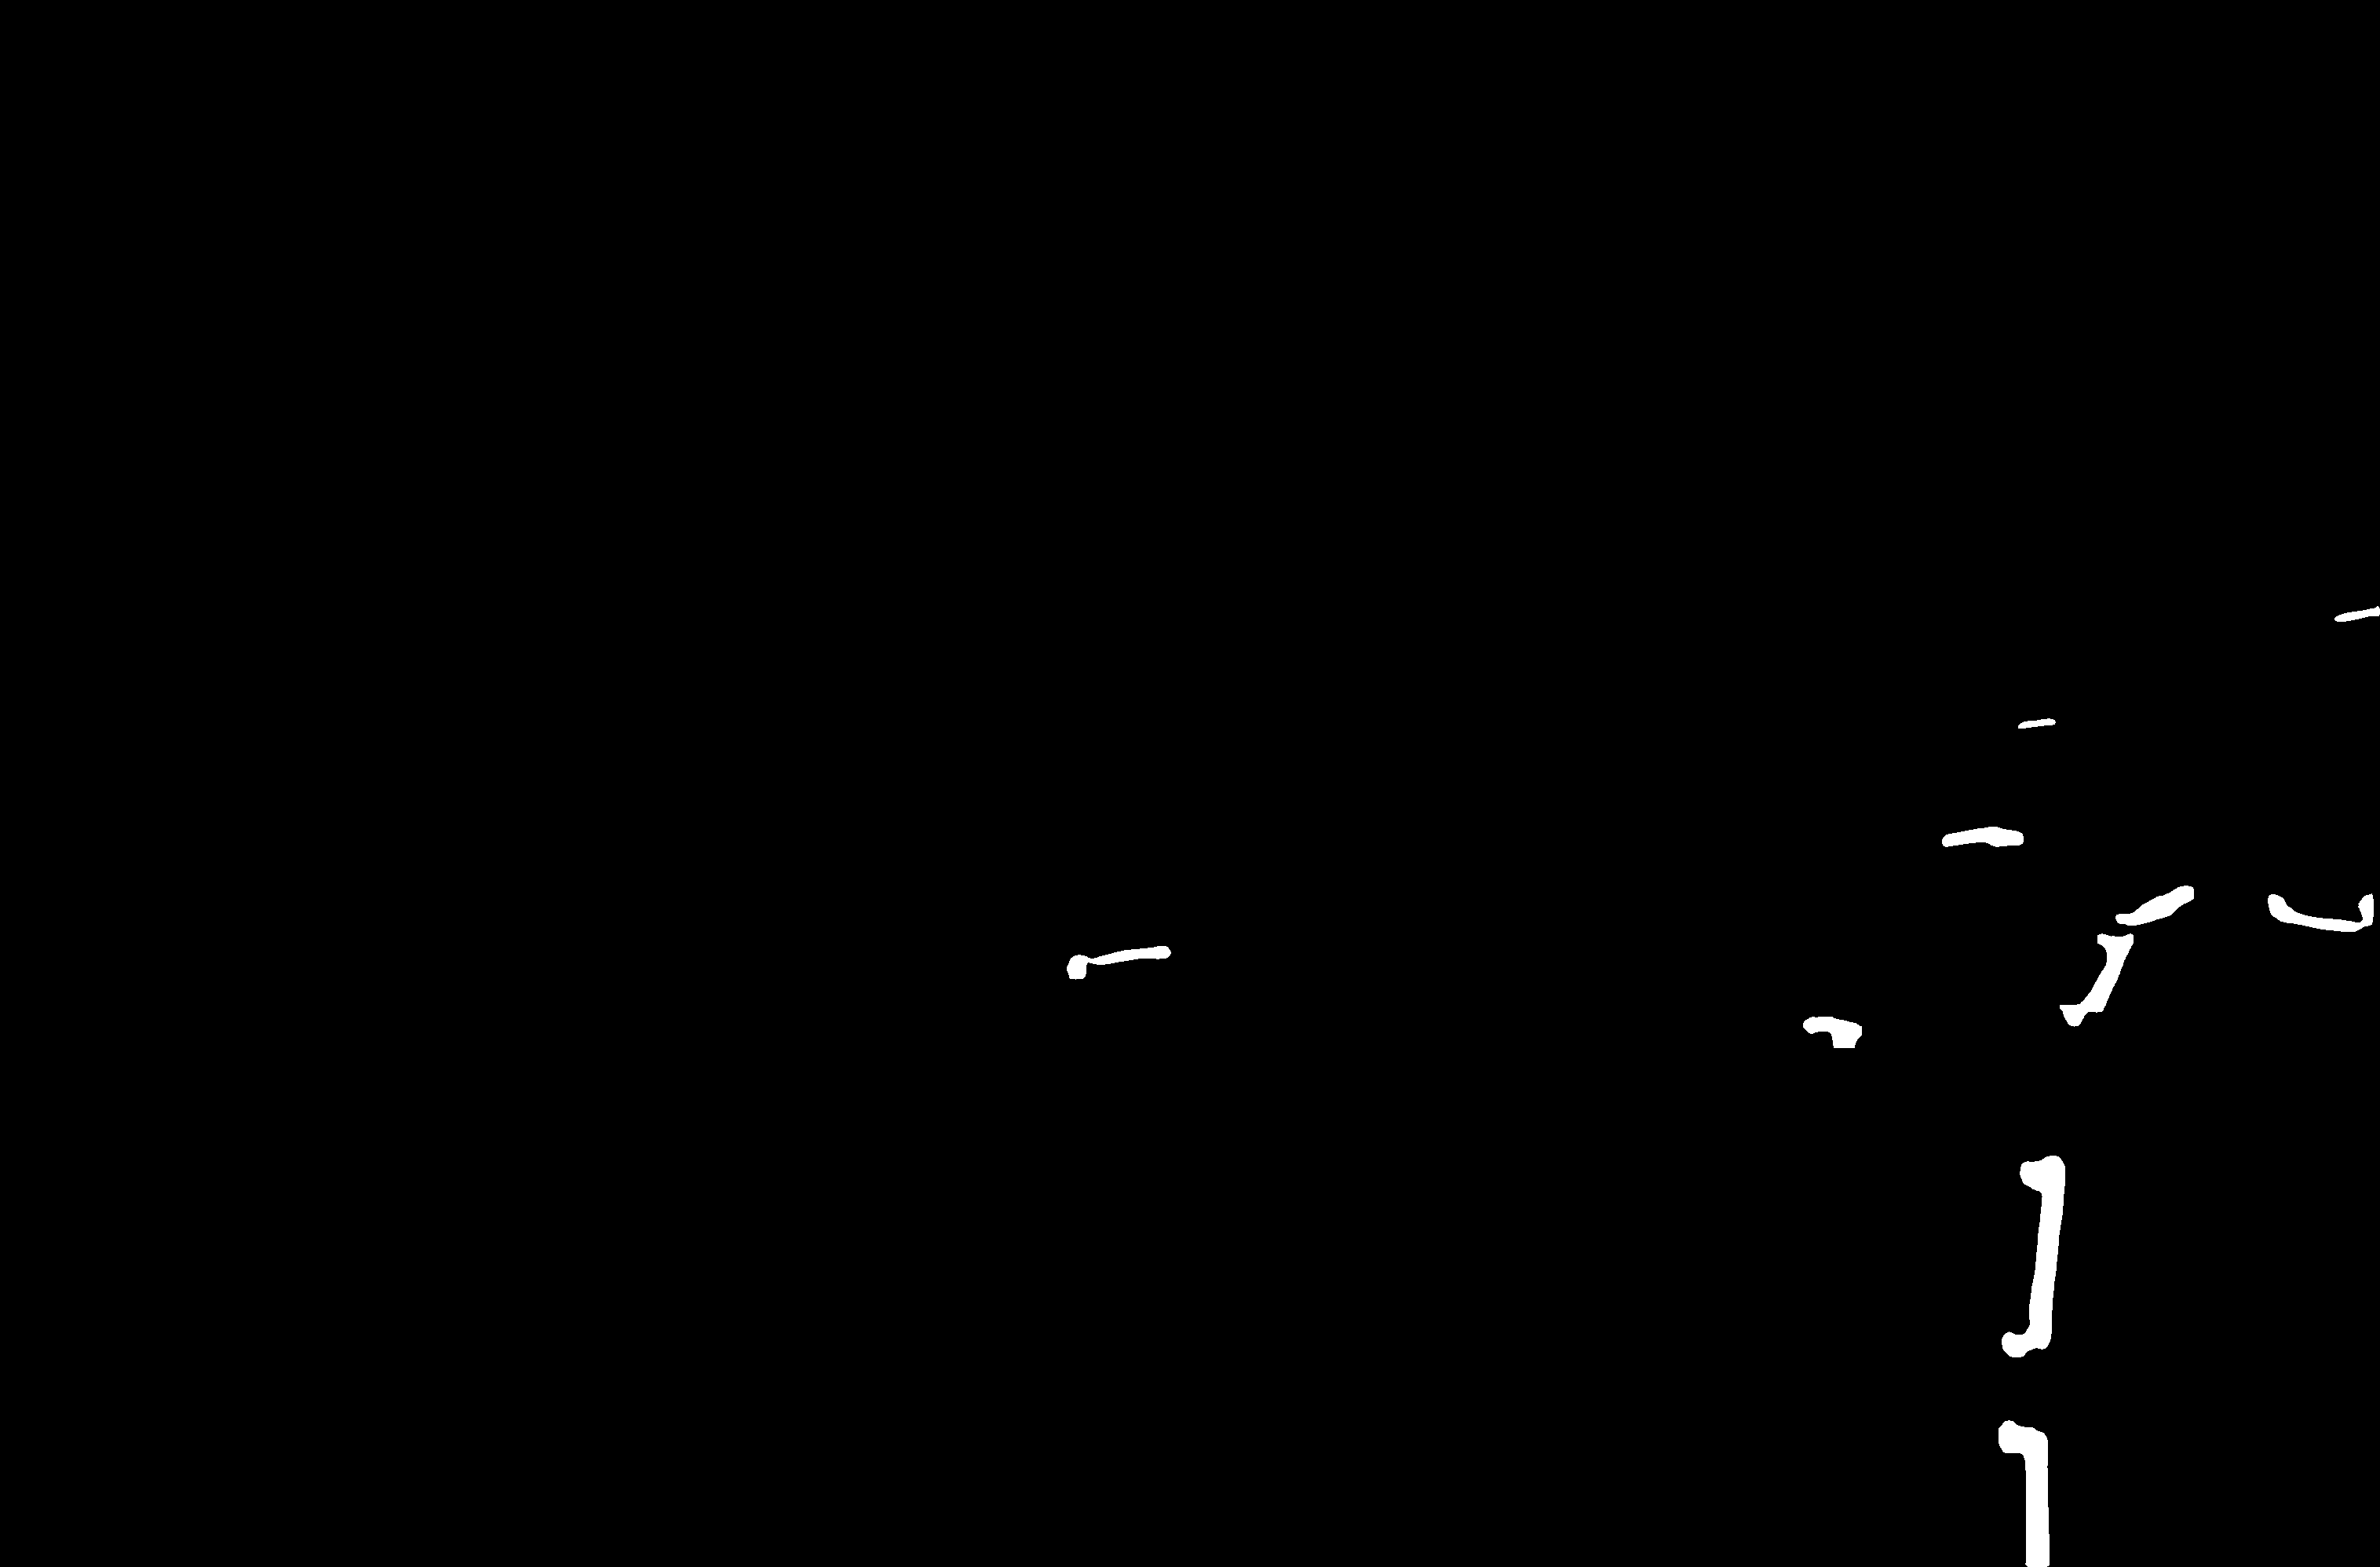

In [ ]:
from PIL import Image 


def displaymask(org_image_path, mask_array):
    num_instances = mask_array.shape[0]
    mask_array = np.moveaxis(mask_array, 0, -1)
    mask_array_instance = []
    img = cv2.imread(str(org_image_path))
    output = np.zeros_like(img)
    for i in range(num_instances):
        mask_array_instance.append(mask_array[:, :, i:(i+1)])
        output = np.where(mask_array_instance[i] == True, 255, output)
    im = Image.fromarray(output)
#    im.save(out_file_name)
    return im 
    

org_image_path = '/content/drive/MyDrive/cku23y4t6bd2a0yduef0yestb.jpg'
maskarray = outputs["instances"].to("cpu").pred_masks.numpy()

#path_to_filename = '/content/drive/MyDrive/inference.jpg'
#cropper(org_image_path, maskarray,path_to_filename)

displaymask(org_image_path, maskarray)




In [ ]:
mask_array = outputs["instances"].to("cpu").pred_masks.numpy()
num_instances = mask_array.shape[0]
mask_array = np.moveaxis(mask_array, 0, -1)
mask_array_instance = []
img = cv2.imread(str(org_image_path))
output = np.zeros_like(img)
for i in range(num_instances):
  mask_array_instance.append(mask_array[:, :, i:(i+1)])
  output = np.where(mask_array_instance[i] == True, 255, output)

In [ ]:

mask_array = outputs["instances"].to("cpu").pred_masks.numpy()
num_instances = mask_array.shape[0]
mask_array = np.moveaxis(mask_array, 0, -1)
mask_array.shape
#_array[:,:,0:1]
newlist = []
#newlist.append(n)
#n.shape
img = cv2.imread(str(org_image_path))
output = np.zeros_like(img)
for i in range(num_instances):
  newlist.append(mask_array[:, :, i:(i+1)])
  output = np.where(newlist[i] == True, 255, output)
#x = np.where(newlist[0] ==True,255,0)
#np.where(x==255)

x = np.where(output==255)



In [ ]:
test_data = [{'file_name': '/content/drive/MyDrive/cku23y4t6bd2a0yduef0yestb.jpg'
              }]

im = cv2.imread(test_data[0]["file_name"])
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
                   metadata=handrail_metadata, 
                   scale=0.5, 
                      # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))


cv2_imshow(out.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#for i in outputs["instances"].pred_masks[0][0]:



h = outputs["instances"].pred_masks[3]
indexes = (h==True).nonzero(as_tuple=True)[0]
indexes.size()

newlist = []

for i in outputs["instances"].pred_masks:

  indexes = (i==True).nonzero(as_tuple=True)[0]
  newlist.append([indexes])



In [ ]:
h = outputs["instances"].to("cpu").pred_masks[0].size()
k = outputs["instances"].to("cpu").pred_masks.size()[0]
#indexes = (h==True).nonzero(as_tuple=True)[0]
#indexes

mylist = []
mydict = {}
for j in range(0, k):
  for i in range(0, h[0]):
    g = outputs["instances"].pred_masks[j][i]
    if True in g:
      indexes = (g==True).nonzero(as_tuple=True)[0]
      mylist.append(indexes)
  mydict[j]=mylist
  mylist = []
mydict

{0: [tensor([2558, 2559, 2560], device='cuda:0'),
  tensor([2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564],
         device='cuda:0'),
  tensor([2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564,
          2565], device='cuda:0'),
  tensor([2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563,
          2564, 2565, 2566], device='cuda:0'),
  tensor([2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562,
          2563, 2564, 2565, 2566, 2567], device='cuda:0'),
  tensor([2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562,
          2563, 2564, 2565, 2566, 2567, 2568], device='cuda:0'),
  tensor([2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560, 2561,
          2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2570], device='cuda:0'),
  tensor([2549, 2550, 2551, 2552, 2553, 2554, 2555, 2556, 2557, 2558, 2559, 2560,
          2561, 2562, 2563, 2564, 2565, 2566, 2567, 2568, 2569, 2

In [ ]:
h = outputs["instances"].to("cpu").pred_masks.size()

#indexes = (h==True).nonzero(as_tuple=True)[0]
h[0]

15

In [ ]:
outputs["instances"]

Instances(num_instances=15, image_height=1996, image_width=3032, fields=[pred_boxes: Boxes(tensor([[2545.1946, 1802.7164, 2611.6396, 1995.9999],
        [2619.4021, 1175.3601, 2719.3093, 1307.9390],
        [2548.5864, 1471.6519, 2631.8557, 1739.2783],
        [2473.2627, 1051.3364, 2578.1050, 1083.7360],
        [1357.2531, 1195.1667, 1503.0792, 1246.6512],
        [2570.5098,  914.0091, 2619.0662,  930.1345],
        [2884.6611, 1134.4755, 3011.1462, 1189.5043],
        [2690.9790, 1124.4628, 2795.6580, 1183.0166],
        [2692.6150, 1152.4438, 2757.2261, 1180.3365],
        [2883.7644, 1136.0057, 3014.0920, 1189.8280],
        [2285.1560, 1283.6732, 2373.0298, 1335.5394],
        [1357.3657, 1196.9579, 1497.5731, 1247.6105],
        [2472.7996, 1054.1412, 2570.7073, 1082.1951],
        [2970.5864,  770.5288, 3031.9998,  792.9815],
        [2883.5105, 1132.3541, 3024.2463, 1187.9581]], device='cuda:0')), scores: tensor([0.9961, 0.9961, 0.9910, 0.9765, 0.9622, 0.8542, 0.4747, 0.4302,

In [ ]:
newlist


[[tensor([1809, 1809, 1809,  ..., 1995, 1995, 1995], device='cuda:0')],
 [tensor([1189, 1189, 1189,  ..., 1306, 1306, 1307], device='cuda:0')],
 [tensor([1472, 1472, 1472,  ..., 1728, 1728, 1728], device='cuda:0')],
 [tensor([1053, 1053, 1053,  ..., 1078, 1078, 1078], device='cuda:0')],
 [tensor([1205, 1205, 1205,  ..., 1246, 1246, 1246], device='cuda:0')],
 [tensor([915, 915, 915, 915, 916, 916, 916, 916, 916, 916, 916, 916, 916, 916,
          916, 916, 916, 916, 916, 916, 917, 917, 917, 917, 917, 917, 917, 917,
          917, 917, 917, 917, 917, 917, 917, 917, 917, 917, 917, 917, 917, 917,
          917, 918, 918, 918, 918, 918, 918, 918, 918, 918, 918, 918, 918, 918,
          918, 918, 918, 918, 918, 918, 918, 918, 918, 918, 918, 918, 918, 918,
          918, 918, 918, 918, 918, 918, 918, 918, 919, 919, 919, 919, 919, 919,
          919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919,
          919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919, 919,


In [ ]:
cv2_imshow(out.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
# HANDRAIL P7
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_handrail_dicts("handrail6/val")
for d in dataset_dicts[0:15]:    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=handrail_metadata, 
                   scale=0.5, 
                      # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    #instance_mode=ColorMode.IMAGE_BW
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("handrail_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "handrail_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

[12/16 08:26:38 d2.evaluation.coco_evaluation]: Trying to convert 'handrail_val' to COCO format ...
[12/16 08:26:38 d2.data.datasets.coco]: Converting annotations of dataset 'handrail_val' to COCO format ...)
[12/16 08:26:43 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[12/16 08:26:43 d2.data.datasets.coco]: Conversion finished, #images: 25, #annotations: 287
[12/16 08:26:43 d2.data.datasets.coco]: Caching COCO format annotations at './output/handrail_val_coco_format.json' ...
[12/16 08:26:47 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    Cone    | 187          |    Ring    | 81           |    Box     | 19           |
|            |              |            |              |            |              |
|   total    | 287          |            |              |            | 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[12/16 08:27:15 d2.evaluation.evaluator]: Inference done 11/25. Dataloading: 0.0030 s/iter. Inference: 0.4338 s/iter. Eval: 0.9747 s/iter. Total: 1.4116 s/iter. ETA=0:00:19
[12/16 08:27:21 d2.evaluation.evaluator]: Inference done 14/25. Dataloading: 0.0032 s/iter. Inference: 0.4488 s/iter. Eval: 1.1721 s/iter. Total: 1.6246 s/iter. ETA=0:00:17
[12/16 08:27:26 d2.evaluation.evaluator]: Inference done 17/25. Dataloading: 0.0032 s/iter. Inference: 0.4567 s/iter. Eval: 1.1864 s/iter. Total: 1.6467 s/iter. ETA=0:00:13
[12/16 08:27:32 d2.evaluation.evaluator]: Inference done 21/25. Dataloading: 0.0031 s/iter. Inference: 0.4571 s/iter. Eval: 1.1500 s/iter. Total: 1.6106 s/iter. ETA=0:00:06
[12/16 08:27:39 d2.evaluation.evaluator]: Inference done 25/25. Dataloading: 0.0029 s/iter. Inference: 0.4542 s/iter. Eval: 1.1531 s/iter. Total: 1.6107 s/iter. ETA=0:00:00
[12/16 08:27:39 d2.evaluation.evaluator]: Total inference time: 0:00:32.400562 (1.620028 s / iter per device, on 1 devices)
[12/16 08:2